# Support Vector Machine (SVM)

In this notebook, we will explore the utilization of SVM models for our classification problem. SVM is chosen for our project due to its capability to handle high-dimensional data and capture complex patterns. Another strength of SVM is its ability to find the optimal decision boundary that maximizes the margin between classes, which often results in better generalization to unseen data. 

We will look into four feature selection methods and analyse their performance. SVM models will be trained utilizing three distinct kernels: 'linear', 'rbf', and 'poly', enabling us to capture intricate relationships within the data. Hyperparameter tuning will be performed on the optimal featues sets. Subsequently, we conduct a comparison of model performance and analyze the strengths and limitations inherent in different SVMs.

## Import Libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from Utils import plotMetricsGraphComparison
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from FeatureSelectionUtils import feature_selection_using_rfecv_on_f1score
from scipy.stats import randint

## Import Train and Test Datasets

In [4]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [5]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Classification Model": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Classification Model": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In [6]:
# Set up a dataframe to store the results from different versions
train_metrics_svm = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics_svm = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

#### Basline model with all features

In [12]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

X_train_basic = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test_basic = pd.read_csv('Data/X_test.csv')[columns]

print("Train Set :", Y_train.shape, X_train_basic.shape)
print("Test Set  :", Y_test.shape, X_test_basic.shape)

Train Set : (20392, 1) (20392, 39)
Test Set  : (8176, 1) (8176, 39)


In [13]:
svm_basic = SVC(random_state=47).fit(X_train_basic, Y_train.values.ravel())
# Predict the output based on our training and testing dataset
Y_train_pred_basic = svm_basic.predict(X_train_basic)
Y_test_pred_basic = svm_basic.predict(X_test_basic)
train_metrics_svm, test_metrics_svm = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Baseline before Feature Engineering", train_metrics_svm, test_metrics_svm)

**Training Set Metrics**
Accuracy 	: 0.8541584935268732
Precision 	: 0.8518121590023383
Recall 		: 0.8574931345625736
F1 Score 	: 0.8546432062561095

**Test Set Metrics**
Accuracy 	: 0.826687866927593
Precision 	: 0.6358974358974359
Recall 		: 0.3686087990487515
F1 Score 	: 0.46669175762137755


## Feature Selection for SVM

The challenge with SVM is that it requires a large amount of computational power and is sensitive to the choice of features. This can make the model more complex and harder to interpret. Another challenge is that independently performing these two steps (feature selection and model training) might result in a loss of information related to the classification process.

We are applying multiple techniques for SVM feature selection:
1. Forward Feature Selection using SVM <br>
Forward Feature Selection gradually builds a robust feature set. This method effectively combats overfitting by prioritizing the inclusion of features that improve model performance, which ensures the selected features are most relevant for classification tasks.
 
2. Backward Feature Selection using SVM <br>
By iteratively removing features based on their impact on model performance, Backward Feature Selection refines the feature set to the most relevant ones. This approach helps mitigate overfitting by eliminating less informative features that might contribute noise to the model. 

3. Univariate Feature Selection <br>
Univariate feature selection is a method used to select the most important features in a dataset. The idea behind this method is to evaluate each individual feature’s relationship with the target variable and select the ones that have the strongest correlation. Univariate feature selection is useful when working with a large number of features and the goal is to reduce the dimensionality of the data and simplify the modeling process. 

4. Recursive Feature Selection <br>
SVMs often encounter challenges with high-dimensional data and susceptibility to overfitting, where RFECV's capability to systematically select the most informative features while mitigating overfitting proves particularly advantageous.

#### Method 1: Forward Feature Selection using Linear SVM

This method requires high amount of computational resources. We are going to select the top features first then apply forward feature selection.

In [13]:
# Select top 10 features using mutual information
selector_mi = SelectKBest(mutual_info_classif, k=20)
X_train_selected_mi = selector_mi.fit_transform(X_train, Y_train.values.ravel())

In [14]:
# Initialize SVM classifier
svm = SVC(kernel='linear', random_state=47)

# Initialize forward feature selector
selector_forward = SFS(svm, 
                       k_features='best', 
                       forward=True, 
                       floating=False, 
                       scoring='f1', 
                       cv=5,
                       verbose=2,
                       n_jobs=-1)

# Perform forward feature selection
selector_forward = selector_forward.fit(X_train_selected_mi, Y_train.values.ravel())

# Get selected feature indices
selected_features_forward = list(selector_forward.k_feature_names_)

# Print selected features
print("Selected features (Forward Selection):", selected_features_forward)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  2.3min remaining:   35.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished

[2024-04-20 16:35:48] Features: 1/20 -- score: 0.7112681754497412[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:  1.7min remaining:   36.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  2.2min finished

[2024-04-20 16:37:59] Features: 2/20 -- score: 0.7129385763996153[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  1.7min remaining:   39.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.2min finished

[2024-04-20 16:40:11] Features: 3/20 -- score: 0.7131227213516613[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17

Selected features (Forward Selection): ['0', '1', '2', '3', '5', '6', '7', '8', '9', '13', '15', '16', '17', '19']


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   52.6s finished

[2024-04-20 18:00:36] Features: 20/20 -- score: 0.7346788178972695

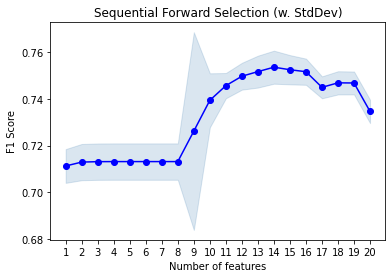

In [15]:
# Plot performance of forward feature selection
fig = plot_sfs(selector_forward.get_metric_dict(), kind='std_dev')

# Add plot labels and title
plt.title('Sequential Forward Selection (w. StdDev)')
plt.ylabel('F1 Score')
plt.xlabel('Number of features')

# Show the plot
plt.show()

We use the selected 14 features to train a basic SVM model.

In [25]:
selected_feature_indices = [int(idx) for idx in selected_features_forward]
svm_forward = SVC(
    random_state=47
).fit(X_train.iloc[:, selected_feature_indices], Y_train.values.ravel())
# Make predictions on the testing data
Y_train_pred_forward = svm_forward.predict(X_train.iloc[:, selected_feature_indices])
Y_test_pred_forward = svm_forward.predict(X_test.iloc[:, selected_feature_indices])

train_metrics_svm, test_metrics_svm = evaluate(Y_train, Y_train_pred_forward, Y_test, Y_test_pred_forward, "Forward Selection", train_metrics_svm, test_metrics_svm)

**Training Set Metrics**
Accuracy 	: 0.6206355433503334
Precision 	: 0.7905054322153992
Recall 		: 0.32826598666143586
F1 Score 	: 0.4638946638946639

**Test Set Metrics**
Accuracy 	: 0.7659001956947162
Precision 	: 0.2734375
Recall 		: 0.08323424494649227
F1 Score 	: 0.1276207839562443


While the cost of missing a cancellation  (false negatives)  is high, precision is also important as we aim to avoid incorrectly predicting cancellations, which could result in customer dissatisfaction. However, the technique's low precision score contradicts our objective. Therefore, we will not consider it for the SVM model.

#### Method 2: Backward Feature Selection using Linear SVM

In [17]:
# Initialize backward feature selector
selector_backward = SFS(svm, 
                        k_features='best', 
                        forward=False, 
                        floating=False, 
                        scoring='f1', 
                        cv=5,
                        verbose=2,
                        n_jobs=-1)

# Perform backward feature selection
selector_backward = selector_backward.fit(X_train_selected_mi, Y_train.values.ravel())

# Get selected feature indices
selected_features_backward = list(selector_backward.k_feature_names_)

# Print selected features
print("Selected features (Backward Selection):", selected_features_backward)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  3.6min remaining:   53.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.6min finished

[2024-04-20 20:36:10] Features: 19/1 -- score: 0.7537084767696104[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:  4.0min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  4.8min finished

[2024-04-20 20:40:59] Features: 18/1 -- score: 0.756061179223152[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  2.9min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.6min finished

[2024-04-20 20:44:35] Features: 17/1 -- score: 0.7564030794061198[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 

Selected features (Backward Selection): ['0', '3', '6', '8', '9', '18', '19']


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   35.8s finished

[2024-04-20 21:15:16] Features: 1/1 -- score: 0.6718843209136041

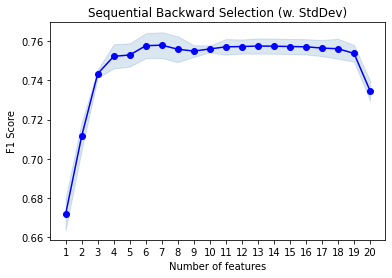

In [18]:
# Plot performance of forward feature selection
fig = plot_sfs(selector_backward.get_metric_dict(), kind='std_dev')

# Add plot labels and title
plt.title('Sequential Backward Selection (w. StdDev)')
plt.ylabel('F1 Score')
plt.xlabel('Number of features')

# Show the plot
plt.show()

We use the selected 7 features to train a basic SVM model.

In [28]:
selected_feature_indices = [int(idx) for idx in selected_features_backward]
svm_backward = SVC(
    random_state=47, kernel = 'linear'
).fit(X_train.iloc[:, selected_feature_indices], Y_train.values.ravel())
# Make predictions on the testing data
Y_train_pred_backward = svm_backward.predict(X_train.iloc[:, selected_feature_indices])
Y_test_pred_backward = svm_backward.predict(X_test.iloc[:, selected_feature_indices])

train_metrics_svm, test_metrics_svm = evaluate(Y_train, Y_train_pred_backward, Y_test, Y_test_pred_backward, "Backward Selection", train_metrics_svm, test_metrics_svm)

**Training Set Metrics**
Accuracy 	: 0.5882208709297764
Precision 	: 0.5936101571443438
Recall 		: 0.5594350725774814
F1 Score 	: 0.5760161575359758

**Test Set Metrics**
Accuracy 	: 0.5233610567514677
Precision 	: 0.24743443557582667
Recall 		: 0.6450653983353151
F1 Score 	: 0.35767265534860726


A F1 score of 0.3577 indicates thay backward feature selection does not work well with SVM model. This may due to the sensitivity of SVMs to the number of features and the potential loss of important discriminatory information when features are removed. Therefore, we will not consider this technique for the SVM model.

#### Method 3: Univariate Feature Selection 

In [53]:
# Select the best features 
selector = SelectKBest(f_classif, k='all') 
selector.fit(X_train, Y_train.values.ravel()) 
X_train_selected_ufs = selector.transform(X_train) 
X_test_selected_ufs = selector.transform(X_test) 

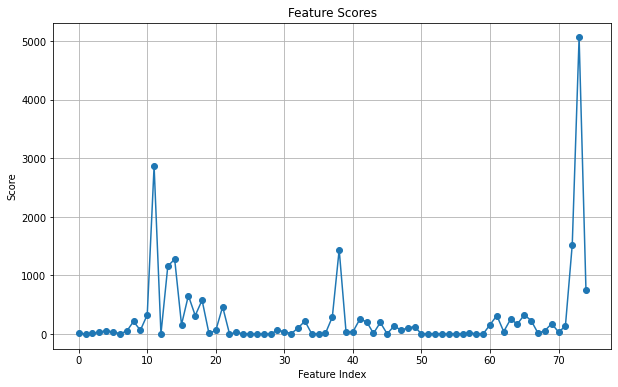

In [50]:
# Plot scores or p-values vs. feature index
plt.figure(figsize=(10, 6))
plt.plot(range(len(selector.scores_)), selector.scores_, marker='o', linestyle='-')
plt.title('Feature Scores')
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.grid(True)
plt.show()

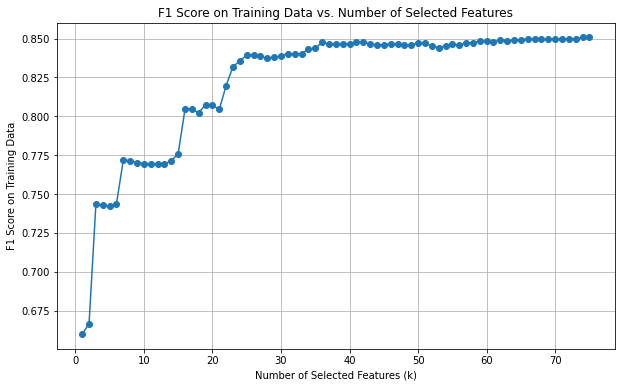

In [52]:
# Initialize SVM classifier
svm = SVC(random_state = 47)

# Initialize SelectKBest with f_classif scoring function
selector = SelectKBest(score_func=f_classif)

# Lists to store F1 scores and number of selected features
train_f1_scores = []
num_features_selected = []

# Iterate over different values of k
for k in range(1, X_train.shape[1] + 1):
    # Fit selector to training data with k features
    selector.set_params(k=k)
    X_train_selected = selector.fit_transform(X_train, Y_train.values.ravel())
    
    # Train SVM classifier on selected features
    svm.fit(X_train_selected, Y_train.values.ravel())
    
    # Make predictions on the training data
    Y_train_pred = svm.predict(X_train_selected)
    
    # Calculate F1 score on the training data
    train_f1 = f1_score(Y_train, Y_train_pred)
    
    # Append F1 score and number of selected features to lists
    train_f1_scores.append(train_f1)
    num_features_selected.append(k)

# Plot F1 score vs. number of selected features
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, train_f1_scores, marker='o')
plt.title('F1 Score on Training Data vs. Number of Selected Features')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('F1 Score on Training Data')
plt.grid(True)
plt.show()


We observe that as the number of selected features (k) increases beyond 25, the corresponding F1 score exhibits a slower rate of increase. This suggests that including additional features beyond this threshold may not significantly improve model performance. Therefore, to strike a balance between feature richness and model complexity, we opt to set k = 25.

In [16]:
# Select the best features 
selector_25 = SelectKBest(f_classif, k= 25) 
selector_25.fit(X_train, Y_train.values.ravel()) 
X_train_selected_ufs = selector_25.transform(X_train) 
X_test_selected_ufs = selector_25.transform(X_test) 

In [22]:
features_ufs_indices = selector_25.get_support(indices=True)
features_ufs = X_train.columns[features_ufs_indices]
features_ufs

Index(['cancellation_type_all_successful', 'cancellation_type_no_booking',
       'lead_time_cat_0 to 50', 'lead_time_cat_150 to 200',
       'lead_time_cat_200 to 300', 'lead_time_cat_50 to 100',
       'lead_time_cat_greater than 300', 'avg_price_per_room_cat_0 to 50',
       'avg_price_per_room_cat_100 to 150', 'avg_price_per_room_cat_50 to 100',
       'booking_dayofweek_3', 'solo_traveller', 'have_special_requests',
       'num_of_customers_and_room_type_mismatch', 'no_of_customers_scaled',
       'no_of_nights_scaled', 'market_segment_type_corporate',
       'market_segment_type_online', 'required_car_parking_space',
       'repeated_guest', 'no_of_adults_scaled', 'no_of_week_nights_scaled',
       'no_of_special_requests_scaled', 'lead_time_scaled',
       'avg_price_per_room_scaled'],
      dtype='object')

In [23]:
svm_selected_ufs = SVC(
    random_state=47
).fit(X_train_selected_ufs,Y_train.values.ravel())
# Make predictions on the testing data
Y_train_pred_selected_ufs = svm_selected_ufs.predict(X_train_selected_ufs)
Y_test_pred_selected_ufs = svm_selected_ufs.predict(X_test_selected_ufs)

train_metrics_svm, test_metrics_svm = evaluate(Y_train, Y_train_pred_selected_ufs, Y_test, Y_test_pred_selected_ufs, "Linear Feature Selected", train_metrics_svm, test_metrics_svm)

**Training Set Metrics**
Accuracy 	: 0.8425362887406826
Precision 	: 0.8564866795957946
Recall 		: 0.8229697920753236
F1 Score 	: 0.839393787825739

**Test Set Metrics**
Accuracy 	: 0.81323385518591
Precision 	: 0.5525423728813559
Recall 		: 0.4845422116527943
F1 Score 	: 0.5163129553373457


#### Method 4: Recursive Feature selection using SVM

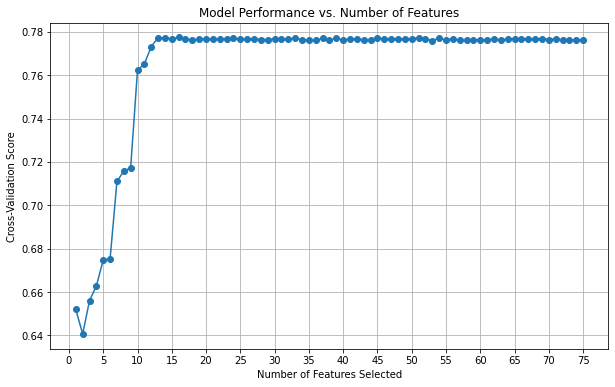

Optimal number of features based on F1 Score: 16


In [27]:
svm = SVC(kernel='linear',random_state=47)
rfecv = feature_selection_using_rfecv_on_f1score(svm, X_train, Y_train)

In [33]:
feature_set_rfecv = list(rfecv[rfecv['selected'] == True]['attribute'])
feature_set_rfecv

['stay_type_hour_room',
 'cancellation_type_no_booking',
 'lead_time_cat_0 to 50',
 'lead_time_cat_100 to 150',
 'lead_time_cat_150 to 200',
 'lead_time_cat_50 to 100',
 'lead_time_cat_greater than 300',
 'avg_price_per_room_cat_0 to 50',
 'avg_price_per_room_cat_200 to 300',
 'avg_price_per_room_cat_greater than 300',
 'have_special_requests',
 'market_segment_type_aviation',
 'market_segment_type_complementary',
 'market_segment_type_online',
 'required_car_parking_space',
 'repeated_guest']

In [24]:
svm_selected = SVC(
    random_state=47
).fit(X_train[feature_set_rfecv], Y_train.values.ravel())
# Make predictions on the testing data
Y_train_pred_selected = svm_selected.predict(X_train[feature_set_rfecv])
Y_test_pred_selected = svm_selected.predict(X_test[feature_set_rfecv])

train_metrics_svm, test_metrics_svm = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Feature Selected", train_metrics_svm, test_metrics_svm)

**Training Set Metrics**
Accuracy 	: 0.7880051000392311
Precision 	: 0.7529502971832199
Recall 		: 0.8572969792075323
F1 Score 	: 0.801742719559734

**Test Set Metrics**
Accuracy 	: 0.7837573385518591
Precision 	: 0.47670639219934996
Recall 		: 0.5231866825208086
F1 Score 	: 0.4988662131519275


In [25]:
test_metrics_svm

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Baseline before Feature Engineering,0.826688,0.635897,0.368609,0.466692
1,Linear Feature Selected,0.813234,0.552542,0.484542,0.516313
2,Feature Selected,0.783757,0.476706,0.523187,0.498866


## Hyperparameter-tuning for Linear SVM


For Linear Support Vector Machines (SVM), the following hyperparameters can be tuned:

1. C (default=1.0): Regularization parameter. The strength of the regularization is inversely proportional to C. Higher values of C allow more flexibility in fitting the training data but may lead to overfitting.

Feature set used for linear SVM comes from univariate selection method, because univariate selection method measures the linear relationship between each feature and the target variable individually.

In [80]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVM
param_grid_linear = {
    'C': [0.1, 1, 10],
}

# Initialize SVM classifier with linear kernel
svm_linear = SVC(kernel='linear', random_state=47)

# Initialize GridSearchCV
grid_search_linear = GridSearchCV(estimator=svm_linear, param_grid=param_grid_linear, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Fit GridSearchCV on training data with selected features
grid_search_linear.fit(X_train_selected_ufs, Y_train.values.ravel())

# Get the best parameters
best_params_linear = grid_search_linear.best_params_

# Evaluate the performance of the tuned model
y_pred_linear = grid_search_linear.predict(X_test_selected_ufs)

print(best_params_linear)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................................C=1; total time=  22.4s
[CV] END ..............................................C=0.1; total time=  19.0s
[CV] END ................................................C=1; total time=  17.0s
[CV] END ..............................................C=0.1; total time=  19.5s
[CV] END ................................................C=1; total time=  16.8s
[CV] END ..............................................C=0.1; total time=  19.6s
[CV] END ...............................................C=10; total time=23.0min
[CV] END ................................................C=1; total time=  19.8s
[CV] END ...............................................C=10; total time=23.4min
[CV] END ................................................C=1; total time=  19.8s
[CV] END ...............................................C=10; total time=32.7min
{'C': 0.1}
[CV] END .............................

In [26]:
svm_linear_tuned = SVC(
    random_state=47,
    kernel = 'linear',
    C = 0.1
).fit(X_train_selected_ufs, Y_train.values.ravel())
# Make predictions on the testing data
Y_train_pred_selected = svm_linear_tuned.predict(X_train_selected_ufs)
Y_test_pred_selected = svm_linear_tuned.predict(X_test_selected_ufs)

train_metrics_svm, test_metrics_svm = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Tuned with linear kernel", train_metrics_svm, test_metrics_svm)

**Training Set Metrics**
Accuracy 	: 0.7742742251863476
Precision 	: 0.7679409792085848
Recall 		: 0.7860925853275794
F1 Score 	: 0.776910774002811

**Test Set Metrics**
Accuracy 	: 0.788160469667319
Precision 	: 0.4858115777525539
Recall 		: 0.5089179548156956
F1 Score 	: 0.4970963995354239


## Hyperparameter-tuning for Non-linear SVM
For Linear Support Vector Machines (SVM), the following hyperparameters can be tuned:

1. C (default=1.0): Regularization parameter. The strength of the regularization is inversely proportional to C. Higher values of C allow more flexibility in fitting the training data but may lead to overfitting.

2. kernel (default='rbf'): Specifies the kernel type to be used in the algorithm. It can be 'poly', 'rbf' (radial basis function), 'sigmoid', or a callable. The choice of kernel influences the decision boundary shape.

3. gamma (default='scale'): Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. Higher values of gamma lead to more complex decision boundaries, potentially leading to overfitting.

4. degree (default=3): Degree of the polynomial kernel function ('poly'). This parameter is ignored for other kernel types.

5. coef0 (default=0.0): Independent term in the polynomial and sigmoid kernels. It is only significant in 'poly' and 'sigmoid' kernels.

Feature set used for **rbf SVM** comes from **Univariate Feature Selection** to prevent overfitting by selecting only the most informative features. However, feature set used for **poly SVM**, which is a less complex kernel, comes from **Recursive Feature Selection (RFE)** because it can identify the non-linear relationships between features and the target variable. 

## Tune kernel rbf

### Tune C

In [100]:
# Define the parameter grid for SVM
param_grid_rbf = {
    'C': [0.1, 1, 10],
}

svm = SVC(kernel = 'rbf', random_state = 47)
grid_search_ker = GridSearchCV(estimator=svm, param_grid=param_grid_rbf, cv=5, scoring='f1', n_jobs=-1, verbose = 2)

# Fit GridSearchCV on training data
grid_search_ker.fit(X_train_selected_ufs, Y_train.values.ravel())

# Get the best parameters
best_params_ker = grid_search_ker.best_params_

# Evaluate the performance of the tuned model
y_pred_ker = grid_search_ker.predict(X_test_selected_ufs)

print("Best kernel parameter:", best_params_ker)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best kernel parameter: {'C': 10}


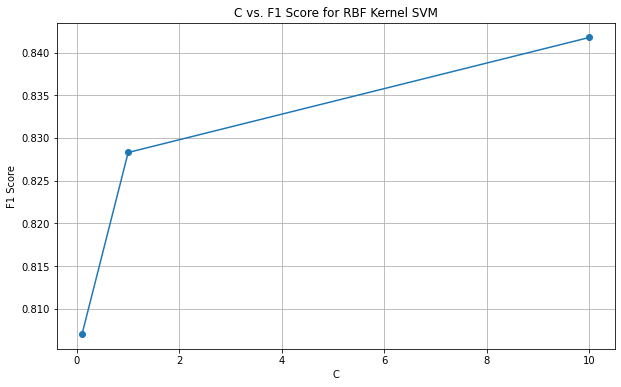

In [101]:
# Get the hyperparameters and corresponding scores
param_values = [params['C'] for params in grid_search_ker.cv_results_['params']]
mean_test_scores = grid_search_ker.cv_results_['mean_test_score']

# Plot C vs. F1 score
plt.figure(figsize=(10, 6))
plt.plot(param_values, mean_test_scores, marker='o', linestyle='-')
plt.title('C vs. F1 Score for RBF Kernel SVM')
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

C = 10 results in a higher performace remarkably. Hence we will stick to C = 10 in the following training for linear SVM.

### Tune gamma

In [113]:
# Define the parameter grid for random search with the specified range
param_dist_rbf = {
    'gamma': np.logspace(-2, np.log10(3), 10)   # Range from 0.01 to 3 in logarithmic scale
}

# Initialize SVM classifier
svm = SVC(kernel='rbf', C=10, random_state=47)

# Initialize RandomizedSearchCV
random_search_ker = RandomizedSearchCV(estimator=svm, param_distributions=param_dist_rbf, n_iter=10, cv=5, scoring='f1', n_jobs=-1, random_state=47, verbose=2)

# Fit RandomizedSearchCV on training data
random_search_ker.fit(X_train_selected_ufs, Y_train.values.ravel())

# Get the best parameters
best_params_ker_random = random_search_ker.best_params_

# Evaluate the performance of the tuned model
y_pred_ker_random = random_search_ker.predict(X_test_selected_ufs)

print("Best kernel parameter (Random Search):", best_params_ker_random)

Best kernel parameter (Random Search): {'gamma': 0.23778172582285131}


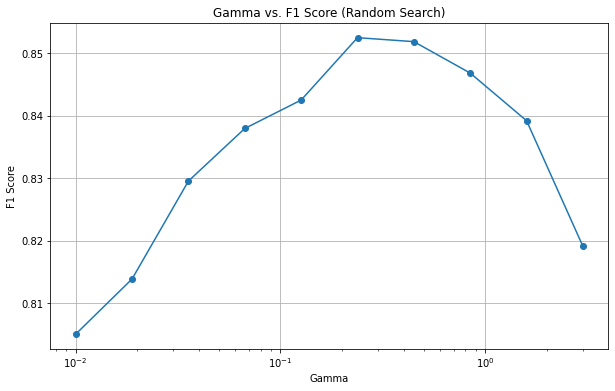

[CV] END .........................gamma=0.018846716378431196; total time=  28.2s
[CV] END ..........................gamma=0.03551987182490267; total time=  27.8s
[CV] END ..........................gamma=0.06694329500821695; total time=  29.1s
[CV] END ..........................gamma=0.23778172582285131; total time=  25.2s
[CV] END ...........................gamma=0.4481404746557166; total time=  34.6s
[CV] END ...........................gamma=1.5917892219322096; total time= 1.3min
[CV] END .........................gamma=0.018846716378431196; total time=  29.0s
[CV] END ..........................gamma=0.03551987182490267; total time=  27.5s
[CV] END ...........................gamma=0.1261661294457514; total time=  30.2s
[CV] END ..........................gamma=0.23778172582285131; total time=  25.0s
[CV] END ...........................gamma=0.8445976423531825; total time=  46.7s
[CV] END ...........................gamma=1.5917892219322096; total time= 1.3min
[CV] END ...................

In [110]:
# Extract gamma values and corresponding F1 scores
gamma_values = [params['gamma'] for params in random_search_ker.cv_results_['params']]
f1_scores = random_search_ker.cv_results_['mean_test_score']

# Plot gamma vs. F1 score
plt.figure(figsize=(10, 6))
plt.plot(gamma_values, f1_scores, marker='o', linestyle='-')
plt.title('Gamma vs. F1 Score (Random Search)')
plt.xlabel('Gamma')
plt.ylabel('F1 Score')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.grid(True)
plt.show()

### With best set of parameters

In [27]:
svm_selected_rbf = SVC(
    random_state=47,
    kernel = 'rbf',
    C = 10,
    gamma = 0.23778172582285131
).fit(X_train_selected_ufs, Y_train.values.ravel())
# Make predictions on the testing data
Y_train_pred_selected = svm_selected_rbf.predict(X_train_selected_ufs)
Y_test_pred_selected = svm_selected_rbf.predict(X_test_selected_ufs)

train_metrics_svm, test_metrics_svm = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Tuned with rbf kernel", train_metrics_svm, test_metrics_svm)

**Training Set Metrics**
Accuracy 	: 0.8874068262063555
Precision 	: 0.8964271376957046
Recall 		: 0.8760298156139663
F1 Score 	: 0.8861111111111112

**Test Set Metrics**
Accuracy 	: 0.8085861056751468
Precision 	: 0.5362229102167183
Recall 		: 0.5148632580261593
F1 Score 	: 0.5253260539884744


## Tune kernel poly

### Tune coef0

In [120]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions for RandomizedSearchCV
param_dist_coef0 = {
    'coef0': randint(0, 20)    
}

# Initialize SVM classifier with polynomial kernel
svm_poly = SVC(kernel='poly', random_state=47)

# Initialize RandomizedSearchCV
random_search_coef0 = RandomizedSearchCV(estimator=svm_poly, param_distributions=param_dist_coef0, n_iter=10, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Fit RandomizedSearchCV on training data
random_search_coef0.fit(X_train[feature_set_rfecv], Y_train.values.ravel())

# Get the best parameters
best_params_coef0 = random_search_coef0.best_params_

# Evaluate the performance of the tuned model
y_pred_coef0 = random_search_coef0.predict(X_test[feature_set_rfecv])

print("Best value for coef0 parameter:", best_params_coef0)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best value for coef0 parameter: {'coef0': 7}


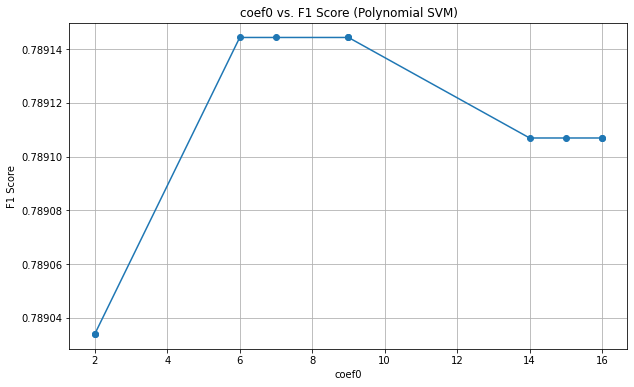

In [124]:
# Sort the parameters and corresponding mean test scores based on the coef0 values
sorted_indices = np.argsort(params_coef0)
sorted_params_coef0 = np.array(params_coef0)[sorted_indices]
sorted_mean_test_scores = np.array(mean_test_scores)[sorted_indices]

# Plot coef0 vs. F1 score using a scatter plot with connected lines
plt.figure(figsize=(10, 6))
plt.plot(sorted_params_coef0, sorted_mean_test_scores, marker='o', linestyle='-')
plt.title('coef0 vs. F1 Score (Polynomial SVM)')
plt.xlabel('coef0')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


The plot shows that coef0 from 6 to 9 leads to better a performance, hence we will stick to range [6,7,8] in the following tuning.

### Tune degree

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best value for degree parameter: {'degree': 6}


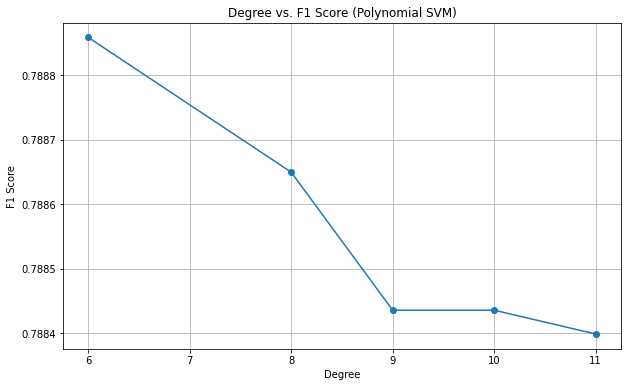

In [8]:
# Define the parameter distributions for RandomizedSearchCV for degree
param_dist_degree = {
    'degree': randint(1, 12)     
}

svm_poly = SVC(kernel='poly', random_state=47)
# Initialize RandomizedSearchCV for degree
random_search_degree = RandomizedSearchCV(estimator=svm_poly, param_distributions=param_dist_degree, n_iter=5, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Fit RandomizedSearchCV on training data for degree
random_search_degree.fit(X_train[feature_set_rfecv], Y_train.values.ravel())

# Get the best parameters for degree
best_params_degree = random_search_degree.best_params_

# Evaluate the performance of the tuned model for degree
y_pred_degree = random_search_degree.predict(X_test[feature_set_rfecv])

print("Best value for degree parameter:", best_params_degree)

# Plot degree vs. F1 score using a scatter plot with connected lines
params_degree = random_search_degree.cv_results_['param_degree']
mean_test_scores_degree = random_search_degree.cv_results_['mean_test_score']

# Sort the parameters and corresponding mean test scores based on the degree values
sorted_indices_degree = np.argsort(params_degree)
sorted_params_degree = np.array(params_degree)[sorted_indices_degree]
sorted_mean_test_scores_degree = np.array(mean_test_scores_degree)[sorted_indices_degree]

# Plot degree vs. F1 score using a scatter plot with connected lines
plt.figure(figsize=(10, 6))
plt.plot(sorted_params_degree, sorted_mean_test_scores_degree, marker='o', linestyle='-')
plt.title('Degree vs. F1 Score (Polynomial SVM)')
plt.xlabel('Degree')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

Models with smaller Degree demonstrate better performance. We will stick with Degree = [4,6,8] in the later stage.

### Tune all parameters with smaller range

In [9]:
# Define the parameter grid for SVM with polynomial kernel
param_grid_poly = {
    'degree': [4, 6, 8],  
    'coef0': [6, 7, 8],    
    'C': [0.1, 1, 10]      
}

svm_poly = SVC(kernel='poly', random_state=47)
grid_search_poly = GridSearchCV(estimator=svm_poly, param_grid=param_grid_poly, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Fit GridSearchCV on training data
grid_search_poly.fit(X_train[feature_set_rfecv], Y_train.values.ravel())

# Get the best parameters
best_params_poly = grid_search_poly.best_params_

# Evaluate the performance of the tuned model
y_pred_poly = grid_search_poly.predict(X_test[feature_set_rfecv])

print("Best parameters for polynomial kernel:", best_params_poly)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for polynomial kernel: {'C': 0.1, 'coef0': 6, 'degree': 6}


In [28]:
# Initialize the SVM classifier with the best parameters for the polynomial kernel
svm_poly = SVC(kernel='poly', degree=best_params_poly['degree'], coef0=best_params_poly['coef0'], C=best_params_poly['C'], random_state=47)

# Fit the SVM model on the training data
svm_poly.fit(X_train[feature_set_rfecv], Y_train.values.ravel())

Y_train_pred_poly = svm_poly.predict(X_train[feature_set_rfecv])
Y_test_pred_poly = svm_poly.predict(X_test[feature_set_rfecv])

train_metrics_svm, test_metrics_svm = evaluate(Y_train, Y_train_pred_poly, Y_test, Y_test_pred_poly, "Tuned with poly kernel", train_metrics_svm, test_metrics_svm)

**Training Set Metrics**
Accuracy 	: 0.7883483719105532
Precision 	: 0.7530556033740747
Recall 		: 0.8580816006276971
F1 Score 	: 0.8021454112038142

**Test Set Metrics**
Accuracy 	: 0.7837573385518591
Precision 	: 0.47673160173160173
Recall 		: 0.523781212841855
F1 Score 	: 0.49915014164305943


## Evaluation

In [29]:
test_metrics_svm

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Baseline before Feature Engineering,0.826688,0.635897,0.368609,0.466692
1,Linear Feature Selected,0.813234,0.552542,0.484542,0.516313
2,Feature Selected,0.783757,0.476706,0.523187,0.498866
3,Tuned with linear kernel,0.788160,0.485812,0.508918,0.497096
4,Tuned with rbf kernel,0.808586,0.536223,0.514863,0.525326
5,Tuned with poly kernel,0.783757,0.476732,0.523781,0.499150


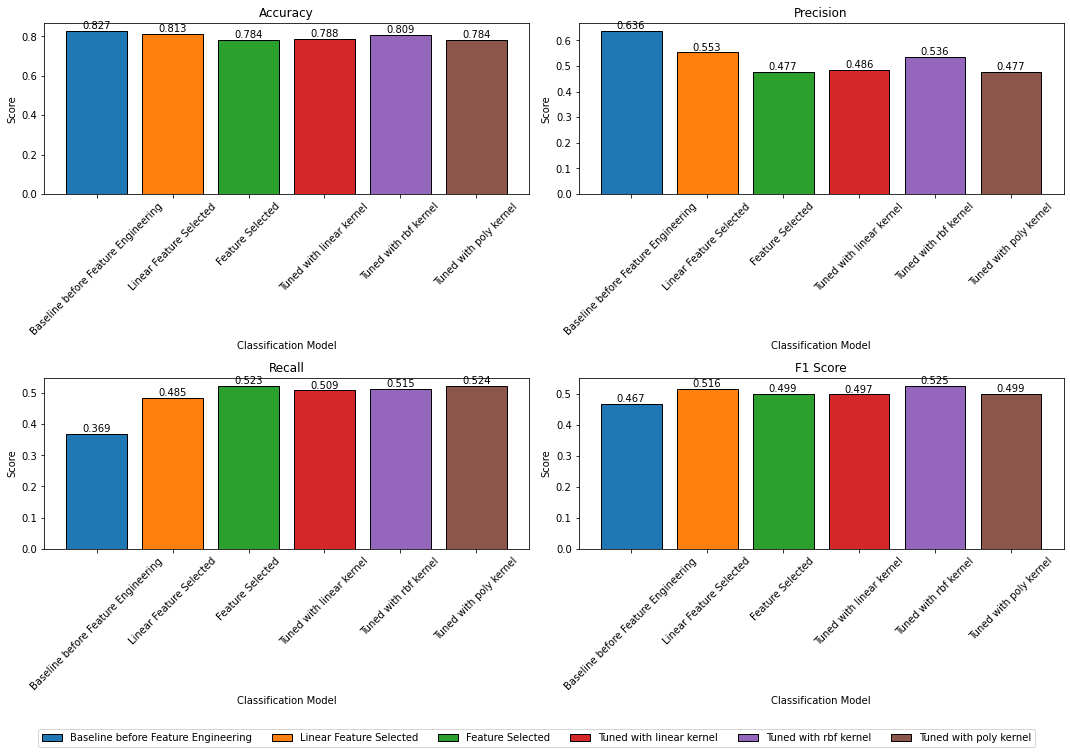

In [32]:
plotMetricsGraphComparison(test_metrics_svm)

SVM with the RBF kernel and hyperparameter tuning, yields the best model performance with an F1 score of 0.525. This may be attributed to its more flexible decision boundaries compared to linear and polynomial kernels, which allows it to adapt to the underlying structure of the data more effectively.  


Interestingly, the baseline model before feature selection demonstrates the highest accuracy and precision among all models, while exhibiting comparatively lower recall and F1 scores. We observe a significant trade-off between precision and recall scores. We can further conclude that feature selection and hyperparameter tuning work well in addressing this problem. 


Additionally, we want to emphasize the notable performance improvement achieved by linear feature selection, which resulted in a 5% increase in the F1 score, surpassing even the non-linear feature selection methods. This outcome underscores the effectiveness of linear feature selection techniques in capturing relevant information for our classification task. This may be attributed to the ability of linear methods to identify the most discriminative features while maintaining simplicity. This also highlights the importance of considering linear feature selection approaches, even in the presence of non-linear relationships in the data.

## Export Best Model

In [33]:
# Exporting the best model to be compared later on
import joblib

joblib.dump(svm_selected_rbf, "FinalModels/BestSVM.pkl") 

['FinalModels/BestSVM.pkl']

In [34]:
# Exporting the features used for this model
from FeatureSelectionUtils import export_final_selected_features_to_csv

export_final_selected_features_to_csv(features_ufs, "Best SVM")

Features exported successfully to FinalModels/Feature_Selection/Best SVM


## Next Steps

Now, after doing feature selection and hyperparameter tuning, the model is exported out such that we can compare this classification model (SVM) with the best feature selection and hyperparameter tuning to other best classification models later.


## To Navigate To The Next Notebook:
0. [Introduction](/0%20-%20Introduction.ipynb) 
1. [Data Cleaning Notebook](/1%20-%20Data%20Cleaning.ipynb) 
2. [Exploratory Data Analyis Notebook](/2%20-%20Data%20Exploration.ipynb)
3. [Data Pre-processing Notebook](/3%20-%20Data%20Pre-Processing.ipynb)
4. [Initial Classification Models Notebook](/4%20-%20ClassificationModels.ipynb)
5. [Feature Engineering Notebook](/5%20-%20Feature%20Engineering.ipynb) 
6. Applying Feature Selection + Hyperparameter Tuning On Individual Models
   1. [Logistic Regression Notebook](/6.1%20-%20Logistic%20Regression.ipynb) 
   2. [K Nearest Neighbour Notebook](/6.2%20-%20K%20Nearest%20Neighbour.ipynb) 
   3. [Decision Tree Notebook](/6.3%20-%20Decision%20Tree.ipynb) 
   4. [Support Vector Machine Notebook](/6.4%20-%20SVM.ipynb) - <b>[You Are Here Now]</b>
   5. [Random Forest Notebook](/6.5%20-%20Random%20Forest.ipynb)
   6. [Adaboost Notebook](/6.6%20-%20Adaboost.ipynb)
   7. [Gradient Boost Notebook](/6.7%20-%20Gradient%20Boosting.ipynb)
   8. [LightGBM Notebook](/6.8%20-%20LightGBM.ipynb)
7.  [Final Model Comparisons + Conclusion Notebook](/7%20-%20Model%20Comparison,%20Final%20Model%20and%20Conclusion.ipynb)